In [3]:
# Cell 1: Import và Load data + Fix nhỏ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)

# Đường dẫn tuyệt đối → tốt, nhưng nên dùng Path cho linh hoạt
from pathlib import Path
BASE_PATH = Path(r"C:\Users\Admin\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs")
DATA_PATH = BASE_PATH / "data" / "processed" / "BGL_structured.csv"

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
print("\nDtypes:")
print(df.dtypes)

print("\nHead:")
print(df.head(3))

print("\nNull count:")
print(df.isnull().sum())

# Fix ngay từ đầu: Chuyển Timestamp thành datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
print(f"\nTimestamp null after convert: {df['Timestamp'].isnull().sum()}")

# Fill null Node/NodeRepeat bằng giá trị phổ biến nhất (mode)
df['Node'].fillna(df['Node'].mode()[0], inplace=True)
df['NodeRepeat'].fillna(df['NodeRepeat'].mode()[0], inplace=True)

print("\nAfter fixing nulls:")
print(df.isnull().sum())

Shape: (100000, 10)

Dtypes:
Label            object
UnixTimestamp     int64
Date             object
Node             object
Timestamp        object
NodeRepeat       object
Component        object
Level            object
Severity         object
Message          object
dtype: object

Head:
  Label  UnixTimestamp        Date                 Node  \
0     -     1117838570  2005.06.03  R02-M1-N0-C:J12-U11   
1     -     1117838570  2005.06.03  R02-M1-N0-C:J12-U11   
2     -     1117838570  2005.06.03  R02-M1-N0-C:J12-U11   

                    Timestamp           NodeRepeat Component   Level Severity  \
0  2005-06-03 15:42:50.363779  R02-M1-N0-C:J12-U11       RAS  KERNEL     INFO   
1  2005-06-03 15:42:50.527847  R02-M1-N0-C:J12-U11       RAS  KERNEL     INFO   
2  2005-06-03 15:42:50.675872  R02-M1-N0-C:J12-U11       RAS  KERNEL     INFO   

                                    Message  
0  instruction cache parity error corrected  
1  instruction cache parity error corrected  
2  instruc

C:\Users\Admin\AppData\Local\Temp\ipykernel_7088\4116038963.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Node'].fillna(df['Node'].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_7088\4116038963.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [4]:
# Cell 2: Cleaning
# Loại bỏ duplicates
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows")

# Normalize text
df['Message'] = df['Message'].str.strip().str.lower()
df['Severity'] = df['Severity'].str.strip().str.lower()
df['Level'] = df['Level'].str.strip().str.lower()

# Sort theo thời gian
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Final shape after cleaning: {df.shape}")

Removed 0 duplicate rows
Final shape after cleaning: (100000, 10)


In [5]:
# Cell 3: Feature Engineering
import numpy as np

# 1. Latency: Khoảng cách thời gian giữa 2 log (giây)
df['Latency'] = df['Timestamp'].diff().dt.total_seconds().fillna(0)

# 2. Giờ trong ngày
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # 0=Mon, 6=Sun

# 3. Độ dài message
df['MsgLength'] = df['Message'].str.len()

# 4. Extract keywords từ Message
def extract_keywords(text):
    if not isinstance(text, str):
        return ""
    # Tìm các từ quan trọng: error, fail, corrected, số, IP, v.v.
    patterns = r'\b(error|fail|fatal|corrected|exception|parity|cache|alignment|ciod|read|prefix|stream|socket)\b'
    nums = r'\b\d+\b'
    ips = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
    
    found = re.findall(patterns, text, re.IGNORECASE)
    found += re.findall(nums, text)
    found += re.findall(ips, text)
    return ' '.join(set(found))  # unique

df['Keywords'] = df['Message'].apply(extract_keywords)

print(df[['Message', 'Keywords', 'Latency', 'Hour']].head(3))

                                    Message                      Keywords  \
0  instruction cache parity error corrected  corrected parity cache error   
1  instruction cache parity error corrected  corrected parity cache error   
2  instruction cache parity error corrected  corrected parity cache error   

    Latency  Hour  
0  0.000000    15  
1  0.164068    15  
2  0.148025    15  


In [6]:
# Cell 4: Labeling Anomaly
# Label gốc: '-' = normal, khác = anomaly
df['Is_Anomaly'] = (df['Label'] != '-').astype(int)

# Bổ sung: Nếu Severity có từ khóa nguy hiểm → coi là anomaly
dangerous_words = ['fatal', 'error', 'fail', 'exception']
df['Severity_Has_Danger'] = df['Severity'].str.contains('|'.join(dangerous_words), case=False).astype(int)

# Kết hợp: Ưu tiên Label gốc, nếu không có thì dùng Severity
df['Anomaly'] = df['Is_Anomaly']
df.loc[(df['Anomaly'] == 0) & (df['Severity_Has_Danger'] == 1), 'Anomaly'] = 1

# Thống kê
anomaly_rate = df['Anomaly'].mean() * 100
print(f"\nAnomaly ratio: {anomaly_rate:.3f}% ({df['Anomaly'].sum():,} / {len(df):,})")

# Xem mẫu anomaly
print("\nSample Anomalies:")
print(df[df['Anomaly'] == 1][['Label', 'Severity', 'Message']].head(3))


Anomaly ratio: 6.262% (6,262 / 100,000)

Sample Anomalies:
     Label Severity                                            Message
4987     -    fatal  ciod: error loading /p/gb2/stella/raptor/65641...
4988     -    fatal  ciod: error loading /p/gb2/stella/raptor/65641...
4989     -    fatal  ciod: error loading /p/gb2/stella/raptor/65641...


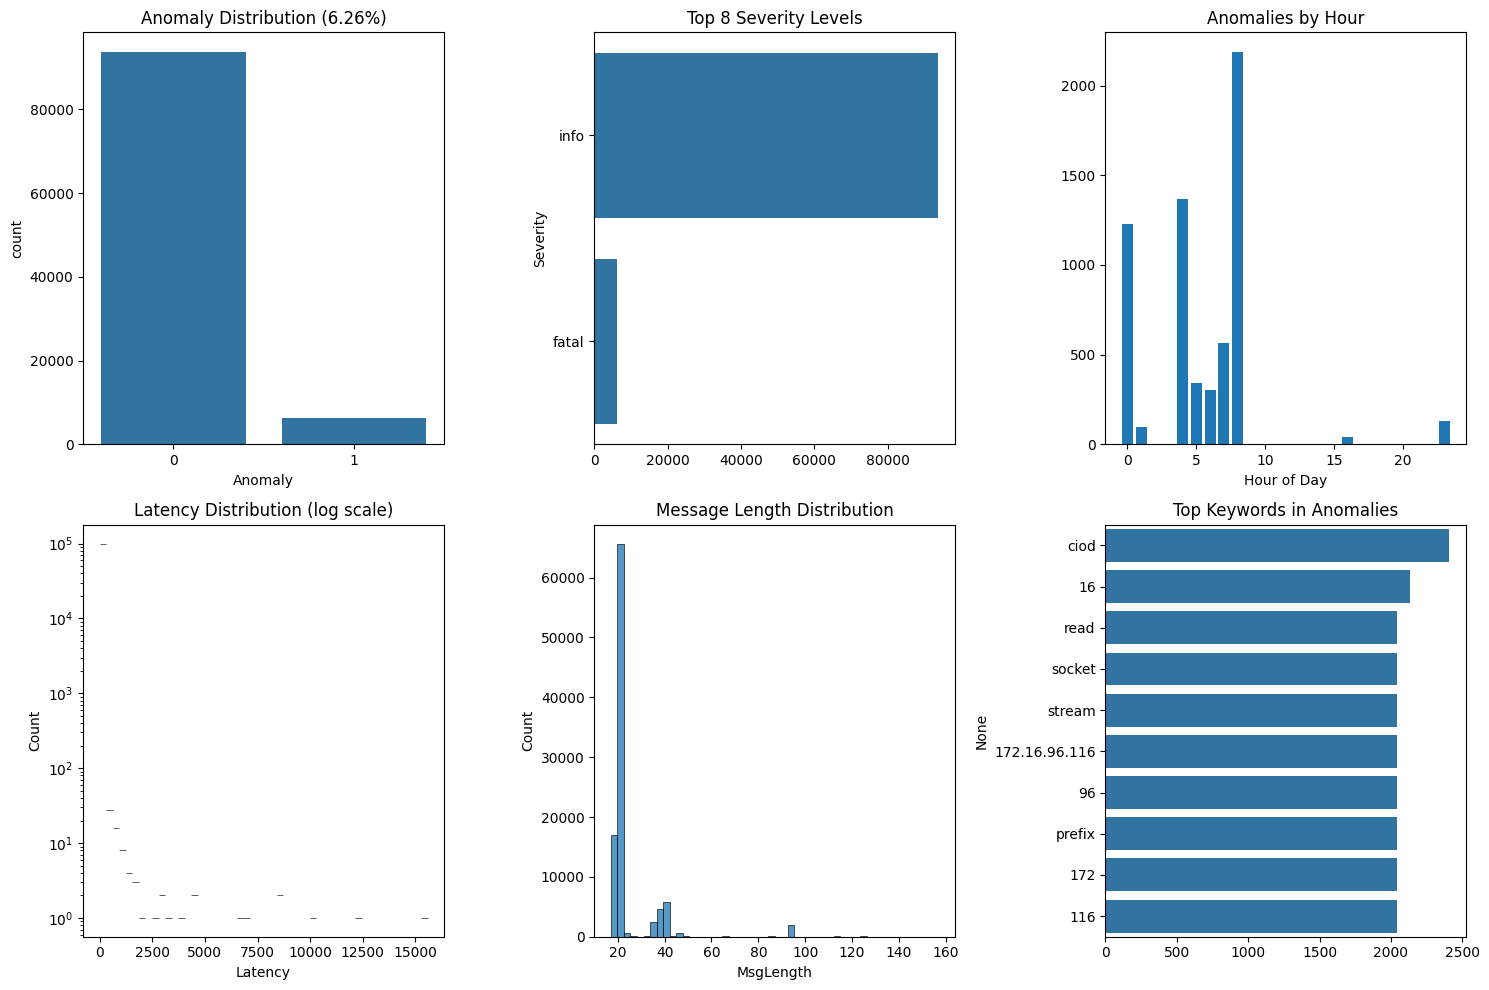

In [7]:
# Cell 5: EDA
plt.figure(figsize=(15, 10))

# 1. Phân bố Anomaly
plt.subplot(2, 3, 1)
sns.countplot(data=df, x='Anomaly')
plt.title(f'Anomaly Distribution ({anomaly_rate:.2f}%)')

# 2. Top Severity
plt.subplot(2, 3, 2)
top_sev = df['Severity'].value_counts().head(8)
sns.barplot(x=top_sev.values, y=top_sev.index)
plt.title('Top 8 Severity Levels')

# 3. Anomaly theo giờ
plt.subplot(2, 3, 3)
anom_by_hour = df[df['Anomaly'] == 1]['Hour'].value_counts().sort_index()
plt.bar(anom_by_hour.index, anom_by_hour.values)
plt.title('Anomalies by Hour')
plt.xlabel('Hour of Day')

# 4. Latency distribution (log scale)
plt.subplot(2, 3, 4)
sns.histplot(df['Latency'], bins=50, log_scale=(False, True))
plt.title('Latency Distribution (log scale)')

# 5. Message length
plt.subplot(2, 3, 5)
sns.histplot(df['MsgLength'], bins=50)
plt.title('Message Length Distribution')

# 6. Top keywords in anomalies
plt.subplot(2, 3, 6)
all_keywords = ' '.join(df[df['Anomaly'] == 1]['Keywords']).split()
keyword_counts = pd.Series(all_keywords).value_counts().head(10)
sns.barplot(x=keyword_counts.values, y=keyword_counts.index)
plt.title('Top Keywords in Anomalies')

plt.tight_layout()
plt.show()

In [8]:
# Cell 6: Save preprocessed data
output_path = BASE_PATH / "data" / "processed" / "BGL_preprocessed.csv"
df.to_csv(output_path, index=False)
print(f"Saved preprocessed data: {output_path}")
print(f"Columns: {list(df.columns)}")

Saved preprocessed data: C:\Users\Admin\Intelligent-Log-Analysis-and-Anomaly-Detection-Assistant-using-RAG-and-LLMs\data\processed\BGL_preprocessed.csv
Columns: ['Label', 'UnixTimestamp', 'Date', 'Node', 'Timestamp', 'NodeRepeat', 'Component', 'Level', 'Severity', 'Message', 'Latency', 'Hour', 'DayOfWeek', 'MsgLength', 'Keywords', 'Is_Anomaly', 'Severity_Has_Danger', 'Anomaly']
